<a href="https://colab.research.google.com/github/ccomkhj/Dacon_Sun/blob/master/Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import os
import glob
import random
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [7]:
train = pd.read_csv('/content/drive/MyDrive/data_solar/train/train.csv')
sub = pd.read_csv('/content/drive/MyDrive/data_solar/sample_submission.csv')

In [8]:
def preprocess_data(data):
	temp = data.copy()
	return temp.iloc[-48:, :]

df_test = []

In [9]:
for i in range(81):
  file_path = '/content/drive/MyDrive/data_solar/test/' + str(i) + '.csv'
  temp = pd.read_csv(file_path)
  temp = preprocess_data(temp)
  df_test.append(temp)

X_test = pd.concat(df_test)
#Attach padding dummy time series
X_test = X_test.append(X_test[-96:])
X_test.shape

(3984, 9)

In [10]:
##=======================Add Td, T-Td and GHI features
def Add_features(data):
  c = 243.12
  b = 17.62
  gamma = (b * (data['T']) / (c + (data['T']))) + np.log(data['RH'] / 100)
  dp = ( c * gamma) / (b - gamma)
  data.insert(1,'Td',dp)
  data.insert(1,'T-Td',data['T']-data['Td'])
  data.insert(1,'GHI',data['DNI']+data['DHI'])
  return data

In [11]:
train = Add_features(train)
X_test = Add_features(X_test)

df_train = train.drop(['Day','Minute'],axis=1)
df_test  = X_test.drop(['Day','Minute'],axis=1)

column_indices = {name: i for i, name in enumerate(df_train.columns)}

#Train and Validation split
n = len(train)
train_df = df_train[0:int(n*0.8)]
val_df   = df_train[int(n*0.8):]
test_df = df_test

# Normalization
num_features = train_df.shape[1]

train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df   =  (val_df - train_mean) / train_std
test_df  = (test_df - train_mean) / train_std

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    #Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
    #Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  def __repr__(self):
    return '\n'.join([
      f'Total window size: {self.total_window_size}',
      f'Input indices: {self.input_indices}',
      f'Label indices: {self.label_indices}',
      f'Label column name(s): {self.label_columns}'])

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # Manually. This way the tf.data.Datasets' are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
def make_dataset(self, data,is_train=True):
  data = np.array(data, dtype=np.float32)
  if is_train==True:
	  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data, targets=None, sequence_length=self.total_window_size, sequence_stride=1, shuffle=True, batch_size=256,)
  else:
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data, targets=None, sequence_length=self.total_window_size, sequence_stride=1, shuffle=False, batch_size=256,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df,is_train=True)

@property
def val(self):
  return self.make_dataset(self.val_df,is_train=True)

@property
def test(self):
  return self.make_dataset(self.test_df,is_train=False)


@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self,'_example', None)
  if result is None:
    #No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
def plot(self, model=None, plot_col='TARGET', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.',zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions',  c='#ff7f0e', s=64)
  if n == 0:
    plt.legend()
  plt.xlabel('Time [30m]')

WindowGenerator.plot = plot

In [17]:
IN_STEPS = 7*24*2
OUT_STEPS = 2*24*2
#Set the data-set 24 hours input -> 48 hours output
w1 = WindowGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift = OUT_STEPS)

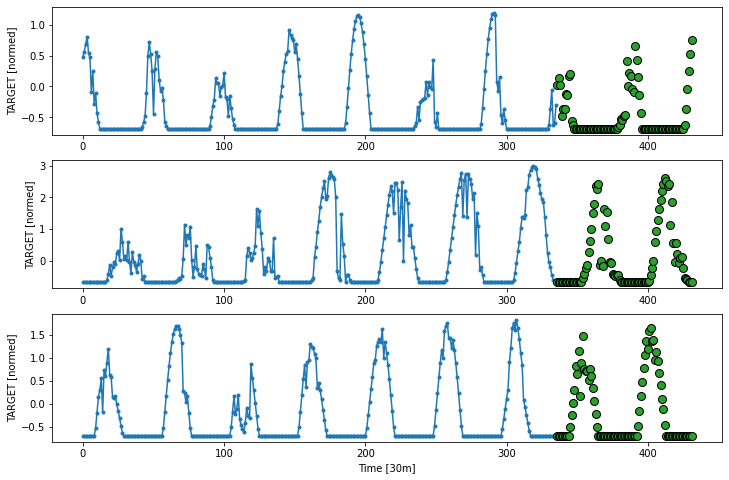

In [18]:
w1.plot()

In [19]:
w1.train.element_spec

(TensorSpec(shape=(None, 336, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 96, 10), dtype=tf.float32, name=None))

In [20]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (256, 336, 10)
Labels shape (batch, time, features): (256, 96, 10)


In [21]:
################# Quantile loss definition
def quantile_loss(q, y_true, y_pred):
	err = (y_true - y_pred)
	return K.mean(K.maximum(q*err, (q-1)*err), axis=-1)

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#########################
OUT_STEPS = 96

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [23]:
########## quantile plot definition

def quantile_plot(self, model=None, plot_col='TARGET', max_subplots=3, quantile=None):
  inputs, labels = self.example
  if quantile == 0.1:
    plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    if quantile == 0.1:
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.',zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    if label_col_index is None:
      continue
    if quantile == 0.1:
      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=20)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='none', label=f'Predictions(q={quantile})', s=15)
    if quantile == 0.9 and n==0:
      plt.legend()
  plt.xlabel('Time [30m]')

WindowGenerator.quantile_plot = quantile_plot

In [24]:
def GRU():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(96),
    tf.keras.layers.GRU(96, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(48), 
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])
    return model

In [ ]:
Dense_actual_pred = pd.DataFrame()
Dense_val_score = pd.DataFrame()

for q in quantiles:
    qq = str(q)
    print('START'+ qq +"QUANTILE")
    model = GRU()
    model.compile(loss = lambda y_true, y_pred: quantile_loss(q, y_true, y_pred), optimizer='adam', metrics=[lambda y, pred: quantile_loss(q, y, pred)])
    history = model.fit(w1.train, validation_data=w1.val, epochs=20, callbacks=[early_stopping])
    pred = model.predict(w1.test, verbose=0)
    target_pred = pd.Series(pred[::48][:,:,9].reshape(7776)) #Save predicted value (striding=48 step, 9 = TARGET) 
    Dense_actual_pred = pd.concat([Dense_actual_pred,target_pred],axis=1)
    Dense_val_score[f'{q}'] = model.evaluate(w1.val)
    w1.quantile_plot(model, quantile=q)

START0.1QUANTILE
Epoch 1/20
163/163 [==============================] - 227s 1s/step - loss: 0.2196 - <lambda>: 0.2196 - val_loss: 0.0924 - val_<lambda>: 0.0924
Epoch 2/20
163/163 [==============================] - 222s 1s/step - loss: 0.0853 - <lambda>: 0.0853 - val_loss: 0.0812 - val_<lambda>: 0.0812
Epoch 3/20
 71/163 [============>.................] - ETA: 2:01 - loss: 0.0779 - <lambda>: 0.0779

In [ ]:
Dense_actual_pred.columns = quantiles
#Denormalizing TARGET values
Dense_actual_pred_denorm = Dense_actual_pred*train_std['TARGET'] + train_mean['TARGET']
#Replace Negative value to Zero
Dense_actual_pred_nn = np.where(Dense_actual_pred_denorm<0, 0, Dense_actual_pred_denorm)

sub.iloc[:,1:] = Dense_actual_pred_nn
sub.to_csv("/content/drive/MyDrive/data_solar/submission/submission_210123_quantile_GRU.csv",index=False)